In [68]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import hvplot.pandas
import libs.montecarlo as mc
import seaborn as sns
import panel as pn
import libs.apis as apis
from panel.interact import interact
import random
from iexfinance.stocks import get_historical_data
import iexfinance as iex
from ta import *

import os
import json
from urllib.request import Request, urlopen

In [69]:
tickers_dict = {"index":["VOO"],
                "crypto":['BTC', 'ETH', 'XRP']}
years = 2
data_start_date = datetime.now() + timedelta(-365*years)

In [70]:
portfolio_hist_prices = apis.get_historic_data(ticker = tickers_dict["index"], 
                                             start_date = data_start_date)
#portfolio_hist_prices.head()

In [71]:
btc_daily_price = apis.get_crypto_daily_price(tickers_dict["crypto"],limit=years*365)
#btc_daily_price.head()

In [72]:
portfolio_hist_prices = pd.concat([portfolio_hist_prices,btc_daily_price],axis=1,join="inner")
portfolio_hist_prices.dropna(inplace=True)
portfolio_hist_prices = portfolio_hist_prices[(portfolio_hist_prices[portfolio_hist_prices.columns] != 0).all(axis=1)]
#portfolio_hist_prices.head()

In [73]:
portfolio_hist_prices = apis.normalize_dataframe(portfolio_hist_prices)
portfolio_daily_retn = portfolio_hist_prices.pct_change().copy()

#portfolio_daily_retn

In [74]:
def corr_plot(portfolio_daily_retn):
    
    title_font = {'family': 'monospace',
            'color':  'blue',
            'weight': 'bold',
            'size': 15,
            }
    correlated = portfolio_daily_retn.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(correlated, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Set up the matplotlib figure
    correlated_plot, ax = plt.subplots(figsize=(7,7))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlated, mask=mask, cmap="coolwarm", vmax=1, vmin =-1, center=0,
                square=True, linewidths=.5, annot=True
                #cbar_kws={"shrink": .5}
               )
    plt.title(f"Correlation Map of Portfolio\n",fontdict=title_font)
    ax.set_facecolor("aliceblue")
    
    #correlated_plot = sns.heatmap(correlated, vmin=-1, vmax=1, annot=True,cmap="coolwarm") 
    plt.close()
    return pn.Pane(correlated_plot)

In [75]:
def get_crypto_news():
    api_key = os.getenv("CC_API")
    url = f"https://min-api.cryptocompare.com/data/v2/news/?lang=EN&api_key={api_key}"
    request = Request(url)
    response = urlopen(request)
    data = response.read()
    url2 = json.loads(data)
    
    return url2


<script async type="text/javascript" src="{{https://widgets.coingecko.com/coingecko-coin-price-marquee-widget.js}}">
</script>
<coingecko-coin-price-marquee-widget  coin-ids="bitcoin,ethereum,litecoin,ripple,zcash" currency="usd" background-color="#ffffff" locale="en">
</coingecko-coin-price-marquee-widget>


In [77]:
def get_corr_pane(portfolio_daily_retn):
    marqu_txt = apis.get_marquee_text()   
   
    footer_text = pn.panel( 
    marqu_txt, 
    align = "center"
    )

    side_text = pn.pane.Markdown(
'''
<style>

body {
    background-color: #FFFFFF;
}

mar {
  color: #000000;
  text-align: center;
  font-family: "Times New Roman", Times, serif;
  font-style: normal;
  font-size: 17px;
}

#leftbox {
    color: black;
}

bold{
    font-weight: bold;
    color: #993300;
    text-align: center;
    font-family: "Times New Roman", Times, serif;
    font-style: oblique;
    font-size: 24px;
    font-variant: small-caps;
}
p {
  color: #000000;
}

p1 {
  color: #006600;
  font-size: 17px;
}

h1 {
    font-size: 30px;
    font-variant: small-caps;
    font-weight: bold;
    font-family: Arial, Helvetica, sans-serif;
}

h2 {
  color: #000000;
  font-family: Arial, Helvetica, sans-serif;
}

h3 {
    color: #000000
    font-size: 16px;
    font-style: italic;
}

cr {
    font-size: 14px;
    font-style: italic;
    color: #33CCFF;
}
</style>
            
<div id="leftbox"> 
<h1>The Correlation Heat Map</h1>
</div>
---
<h2> What is Correlation?</h2>

<p1> Correlation between sets of data is a measure of how well they are related. The most common measure of correlation in stats is the Pearson Correlation. 
The full name is the Pearson Product Moment Correlation (PPMC). It shows the linear relationship between two sets of data. In simple terms, it answers the question, Can I draw a line graph to represent the data? </p1>
<cr><a href='https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/correlation-coefficient-formula/#Pearson', 
target="_blank"> Statistics How To</a></cr> 
<br><p>Learn more at <a href='https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/correlation-coefficient-formula/#Pearson', target="_blank">https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/correlation-coefficient-formula/#Pearson</a>
''',
        align= "center",
        width_policy = "max",
    )
    
    lower_text = pn.pane.Markdown('''
<h3><bold>Important:</bold> &nbsp;Correlation does not imply causation!</h3>
---
        ''',
                                  align= "center",
                                  width_policy = "max",
                                  margin=(0, 50),
                                 )###??????????
    #WARNING:param.Markdown11741: Setting non-parameter attribute
    #max_with=5 using a mechanism intended only for parameters
    left_row = pn.Row(side_text, align="start")
    middle_row = pn.Row(corr_plot(portfolio_daily_retn),align="center", width_policy="fit")
    both_row = pn.Row(left_row, middle_row)
    
    corr_pane = pn.Column(both_row,lower_text,footer_text,align="center", sizing_mode='stretch_both')
    
    return corr_pane
    

Column(align='center', sizing_mode='stretch_both')
    [0] Row
        [0] Row
            [0] Markdown(str, align='center', width_policy='max')
        [1] Row(align='center', width_policy='fit')
            [0] Matplotlib(Figure)
    [1] Markdown(str, align='center', margin=(0, 50), width_policy='max')
    [2] Markdown(str, align='center')
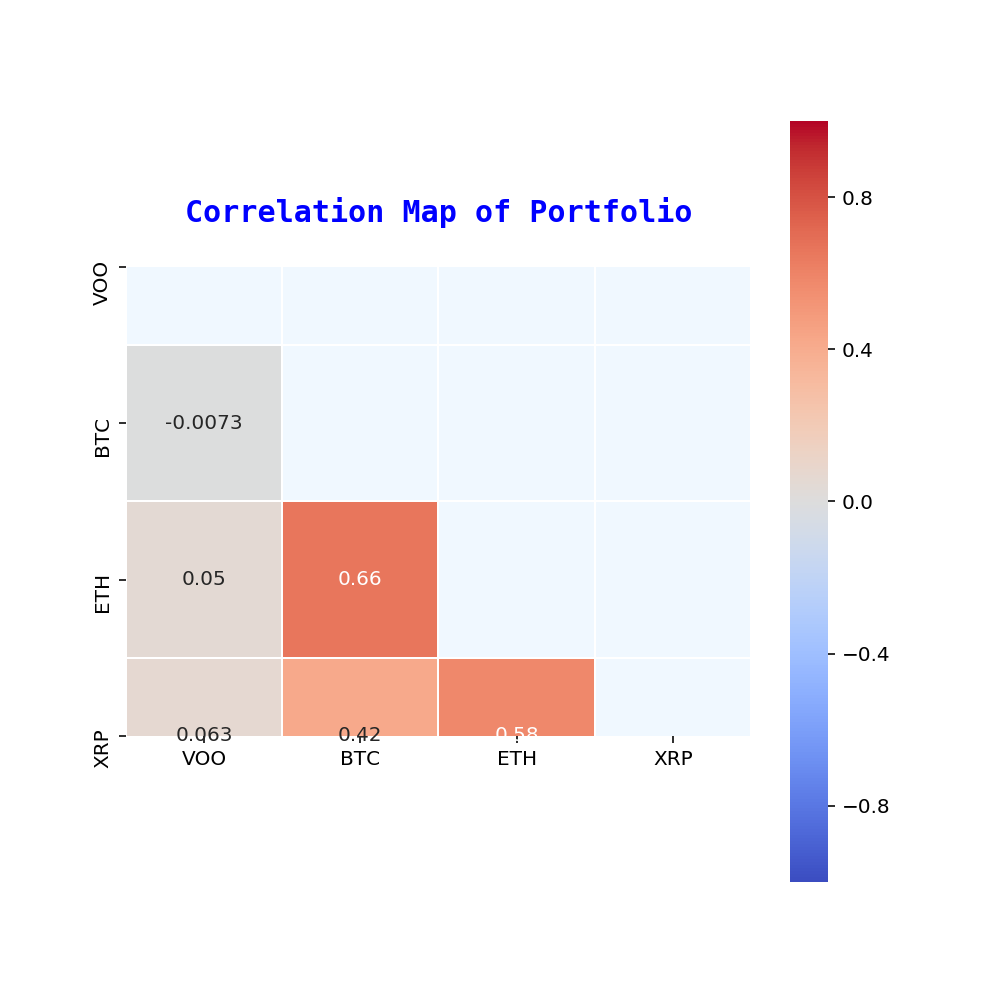

In [78]:
get_corr_pane(portfolio_daily_retn)

In [79]:
def sharp_rt_plot(portfolio_daily_retn):
    
    title_font = {'family': 'monospace',
            'color':  'blue',
            'weight': 'bold',
            'size': 15,
            }
    label_font = {'family': 'monospace',
            'color':  'green',
            'weight': 'bold',
            'size': 12,
            }
   # bar_colors=["orange","plum","yellowgreen","indigo","wheat","salmon","lightblue","purple","gold",
    #           "cornflowerblue","mediumslateblue","seagreen","peru"]
    bar_colors=["midnightblue","royalblue","indigo","darkcyan","darkgreen","maroon",
               "purple","darkorange","slategray","forestgreen"]

    sharp_ratios = portfolio_daily_retn.mean()*np.sqrt(252)/portfolio_daily_retn.std()
    
    sr_plot = plt.figure();
    plt.bar(x = sharp_ratios.index, height=sharp_ratios, color=random.sample(bar_colors,len(sharp_ratios.index)))
    plt.title(f"Sharp Ratios of Portfolio\n",fontdict=title_font)
    plt.ylabel("Sharp Ratio",fontdict=label_font)
    plt.xlabel("Assets",fontdict=label_font)
    plt.axhline(sharp_ratios.mean(), color='r')
    
    
    plt.close()
    return pn.Pane(sr_plot)

In [80]:
def get_sharp_pane(portfolio_daily_retn):
    footer_text = pn.panel(
        
    "<marquee> <bold>The latest news on crypto and finance here:</bold>&nbsp;<mar> BTC up 20,000.00% in last year, 7.77% today,&nbsp;"
    +" ETH up 400,000.00% in the last year, 9.99% today,&nbsp; "
    +" Trump lost re-election due to poor results,&nbsp; Global peace achieved yesterday at UN,&nbsp; "
    +" S&P500 down 10% in the last year, down 1.21%, today,&nbsp; "
    +"cryptocurrencies are being used more than dollar for international trading,&nbsp; XRP up 27.89% today,&nbsp; "
    +" Satoshi just gave away his millions of BTC to the most needed people in the developing world,&nbsp; "
    +" military war on drugs has been replaced by an educational war "
    +"on drugs and regulation of legal point of sales,&nbsp; drug cartels in bankruptcy, &nbsp;"
    +" Colombians achieved peace for first time in more than 60 years...&nbsp;</mar></marquee>", 
    align = "center"
    )

Matplotlib(Figure)
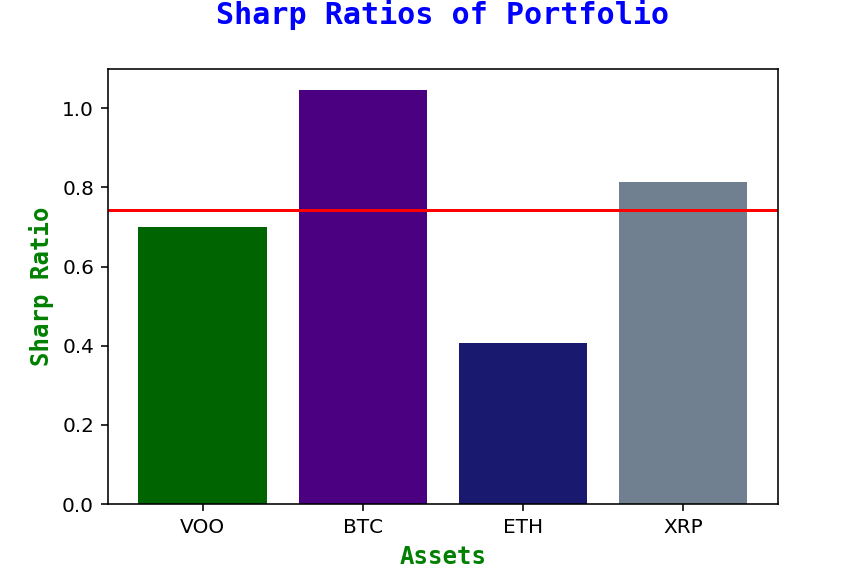

In [81]:
plot = sharp_rt_plot(portfolio_daily_retn)
plot

In [82]:


def plot_mont_carl(monte_carlo_sim):
    plot_title = f"Monte-Carlo Simulation of Portfolio"
    monte_carlo_sim_plot = monte_carlo_sim.hvplot(title=plot_title,figsize=(18,10),legend=False)
    return monte_carlo_sim_plot

In [83]:
def get_conf_interval(db,q=[0.05, 0.95]):
    confidence_interval = db.iloc[-1].quantile(q=q)
    return confidence_interval

In [84]:
def plot_conf(values=None,conf=[0,0]):
    bar_colors=["midnightblue","royalblue","indigo","black","darkcyan","darkgreen",
               "purple","darkorange","slategray"]
    conifidence_plot = plt.figure(figsize=(12,8));
    #plt.plot(values,kind='hist', density=True, bins=20)
    plt.hist(x = values,bins=20, color = random.choice(bar_colors))
    plt.axvline(conf.iloc[0], color='r')
    plt.axvline(conf.iloc[1], color='r')
    plt.close()
    return pn.Pane(conifidence_plot)

#### **New Code for TA functions**
_Christian_

---

In [85]:
def get_crypto_olhc(crypto_ticker, allData=False,limit = 90):
    """
    Returns a dataframe with all features needed for ta lib see
    https://technical-analysis-library-in-python.readthedocs.io/en/latest/ for more information about ta for python. 
    Arguments:
    cryptoticker: Crypto ticker in string format.
    allData: if True, gets all historical data available and ignores argument "limit".
    By default it is False.
    limit: the days from now to get the historical data. By default it's 90.
    """
    api_key = os.getenv("CC_API")

    if allData:
        url = f"https://min-api.cryptocompare.com/data/v2/histoday?fsym={crypto_ticker}&tsym=USD&allData=true&api_key={api_key}"
    else:
        url = f"https://min-api.cryptocompare.com/data/v2/histoday?fsym={crypto_ticker}&tsym=USD&limit={limit}&api_key={api_key}"

    raw_data = apis.read_json(url)
    crypto_df = pd.DataFrame(raw_data['Data']['Data'])
    crypto_df['time'] = pd.to_datetime(crypto_df['time'],unit='s')
    ta_df = add_all_ta_features(crypto_df, "open", "high", "low", "close", "volumefrom", fillna=True)      

    return ta_df

In [86]:
ta_df = get_crypto_olhc('ZEC', allData=False, limit=30)

C:\Users\cscat\Anaconda3\lib\site-packages\ta\trend.py:170: RuntimeWarning: divide by zero encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
C:\Users\cscat\Anaconda3\lib\site-packages\ta\trend.py:170: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
C:\Users\cscat\Anaconda3\lib\site-packages\ta\trend.py:174: RuntimeWarning: divide by zero encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])
C:\Users\cscat\Anaconda3\lib\site-packages\ta\trend.py:174: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])
C:\Users\cscat\Anaconda3\lib\site-packages\ta\trend.py:176: RuntimeWarning: invalid value encountered in subtract
  dx = 100 * np.abs((dip - din) / (dip + din))


In [87]:
ta_df.head()

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,volume_adi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
0,2019-08-23,52.99,48.98,50.72,440900.01,22504697.17,51.04,multiply,BTC,-57122.815572,...,100.000000,100.000000,64.923987,51.371571,51.371571,-48.628429,0.0,7.609753,0.000000,0.000000
1,2019-08-24,50.98,49.45,51.04,365029.80,18354956.52,50.28,multiply,BTC,43110.117912,...,55.082014,85.932068,62.094482,32.418953,41.895262,-67.581047,0.0,-1.489028,-1.500226,-1.489028
2,2019-08-25,51.14,50.03,50.28,366013.73,18378209.76,50.21,multiply,BTC,-216290.970403,...,37.925009,80.538166,55.928761,30.673317,38.154613,-69.326683,0.0,-0.139220,-0.139317,-1.626176
3,2019-08-26,53.16,50.10,50.21,586419.36,30232886.66,51.56,multiply,BTC,-274136.218246,...,58.901317,78.760203,53.707609,61.722488,41.604919,-38.277512,0.0,2.688707,2.653197,1.018809
4,2019-08-27,51.08,49.56,51.56,362495.09,18306312.92,50.50,multiply,BTC,59024.456342,...,48.924634,72.802859,52.700412,36.363636,42.919814,-63.636364,0.0,-2.055857,-2.077284,-1.057994


In [88]:
def bb_plot(df):
    bb_plot = plt.figure(figsize=(12,8));
    plt.plot(df.close)
    plt.plot(df.volatility_bbh, label='High BB')
    plt.plot(df.volatility_bbl, label='Low BB')
    plt.plot(df.volatility_bbm, label='EMA BB')
    plt.title('Bollinger Bands')
    plt.legend()
    plt.close()
    return pn.Pane(bb_plot)

In [89]:
def ichi_plot(df):
    ichi_plot = plt.figure(figsize=(12,8));
    plt.plot(df.close)
    plt.plot(df.trend_ichimoku_a, label='Ichimoku a')
    plt.plot(df.trend_ichimoku_b, label='Ichimoku b')
    plt.title('Ichimoku Kinko Hyo')
    plt.legend()
    plt.close()
    return pn.Pane(ichi_plot)

In [90]:
def ema_plot(df):
    ema_plot = plt.figure(figsize=(12,8));
    plt.plot(df.close)
    plt.plot(df.volatility_bbm, label='EMA BB')
    plt.title('Exponential Moving Average')
    plt.legend()
    plt.close()
    return pn.Pane(ema_plot)

In [91]:
def macd_plot(df):
    macd_plot = plt.figure(figsize=(12,8));
    plt.plot(df.trend_macd, label='MACD');
    plt.plot(df.trend_macd_signal, label='MACD Signal')
    plt.plot(df.trend_macd_diff, label='MACD Difference')
    plt.title('MACD, MACD Signal and MACD Difference')
    plt.legend()
    plt.close()
    return pn.Pane(macd_plot)

#### End New Code for TA

---

# DASHBOARD TIME!!!

In [92]:
#print(portfolio_hist_prices.head())

In [93]:
portfolio_hist_prices = portfolio_hist_prices[(portfolio_hist_prices[portfolio_hist_prices.columns] != 0).all(axis=1)]
#portfolio_hist_prices.any()
#portfolio_hist_prices.head()

In [94]:
mc_sim = mc.monte_carlo_sim(portfolio_hist_prices,trials = 50)

In [95]:
risk_tabs = pn.Tabs(
    ("Correlation of portfolio",get_corr_pane(portfolio_daily_retn)),
    ("Sharp Ratios", sharp_rt_plot(portfolio_daily_retn)),
#    background="whitesmoke"
)

In [96]:
montecarlo_tabs = pn.Tabs(
    ("monte Carlo Simulation",plot_mont_carl(mc_sim)),
    ("Confidence Intervals", plot_conf(mc_sim.iloc[-1],get_conf_interval(mc_sim))),
#    background="whitesmoke"
)

In [97]:

techl_analysis_tabs = pn.Tabs(
    ("Exp. Moving Avg.",ema_plot(ta_df)),
    ("Bollinger Bands", bb_plot(ta_df)),
    ("MACD",macd_plot(ta_df)),
    ("Ichimoku Kinkō Hyō", ichi_plot(ta_df)),
#    background="whitesmoke"
)

In [98]:
tabs = pn.Tabs(
    ("Risk",risk_tabs),
    ("Monte Carlo Simulation", montecarlo_tabs),
    ("Tecnical Analysis", techl_analysis_tabs),
    ("Report", "in construction"),
    tabs_location = "left",
    align = "start"
)
  

In [99]:
  
panel = tabs

panel.show()